# Memristive Nanowire Network Simulations

This notebook explores the memristive nanowire networks of the Nano Functionality Integration Group. After defining the network simulation, it runs several experiments on the resulting networks.

---

# Simulation Code

First, create programmatical definitions of nanowires, junctions, electrodes, and their interactions. This is stored in a single Jupyter cell so it can be loaded with only one run command. In JupyterLab (not Jupyter notebook) this can be hidden to view the later experiments more easily via the "view > collapse selected code" menu item.

The previously simulated memristic nanowire network used asymmetric junctions---that is, switches that decreased in resistance from one current, but increased in resistance with the opposite. However, the construction of PVP/Ag nanowires is symmetric. It seems reasonable to assume that, if resistance decreases by ion bridge forming by current, any current, in any direction, will do so. Electromigration.

They say the junctions dissolve over time. Thus, we propose the following model, kinda ungrounded in physical reality:

First, as before, in a junction,

$$V=\left[R_{on}\cdot\frac{w}{w_0} + R_{off}\cdot*\left(1-\frac{w}{w_0}\right)\right]\cdot I,$$

just as before, and, differently,

$$\frac{dw}{dt} = \mu_v\cdot\frac{R_{on}}{w_0}\cdot|I| - \tau\cdot w - \eta,$$

where all variables are the same as before. That is, $w_0$ is the total junction width (m), $w$ is the current width of the ion bridge inside the junction (m) ($w\in[0,w_0]$), $R_{on}$ and $R_{off}$ (Ω) are the resistances of the total junction when bridged or empty, respectively, $V$ (V) and $I$ (A) are the current through the junction, $\mu_v$ is the ion mobility ($m^2/(s*V)$), and $\eta$ is noise defined by a normal distribution with mean zero and standard deviation proportional to $\frac{dw}{dt}$ meant to model ion availability.

Let's see how this acts using the previously developed functions, modified for this model.

In [1]:
# import any external libraries

import math # several basic trigonometric functions 
import random # generate random nanowire positions, etc.
import scipy.stats as stats # generate gamma-distributed nanowire lengths
import numpy as np # linear algebra routines
import matplotlib.pyplot as plt # graphing library
import matplotlib.patches as patches # to graph electrodes
try:
    import pywren # for Amazon cloud parallel computing
except:
    print('Error: pywren is not installed.')
from ipywidgets import FloatProgress; from IPython.display import display # progress bars

# define network parts

def new_nanowire(start=np.array((0, 0)), end=np.array((1, 1))):
    """Create a new nanowire.

    Keyword arguments:
    start, end -- endpoint coordinates in um as 2 element numpy array
    end -- same
    """
    return {'start':start, 'end':end, # endpoint coordinates in um
            'min':(min(start[0], end[0]), # for bounding box checks
                   min(start[1], end[1])),
            'max':(max(start[0], end[0]),
                   max(start[1], end[1])),
            'electrodes':[], 'junctions':[]} # indices of connected items

def new_junction(position=(0, 0), start=0, end=0):
    """Create a new junction.

    Keyword arguments:
    position -- coordinates in um as 2-tuple
    start, end -- nanowire indices
    """
    return {'position':position, # tuple that stores coordinates in um
            'start':start, 'end':end, # nanowire indices
            'nanowires':{start, end}} # for connectivity algorithm

def new_electrode(x_pos=0, y_pos=0, width=0, height=0):
    """Create a new electrode."""
    return {'x':x_pos, 'y':y_pos, 'w':width, 'h':height}

# define functions to create a network

def create_nanowires(params={'electrodes':[],
                             'xmin':0, 'xmax':100, 'ymin':0, 'ymax':100,
                             'density':0.5,
                             'lalpha':5.77, 'lloc':-0.65, 'lbeta':0.88,
                             'seed':0}):
    """Form an array of nanowires and compute electrode intersections.

    Keyword arguments:
    params -- dictionary of nanowire parameters:
        electrodes -- list of electrodes
        density -- number of nanowires per square um
        xmin, xmax, ymin, ymax -- the uniform range of nanowire centerpoints, in um
        lalpha, lloc, lbeta -- the gamma distribution of nanowire lengths in um
        seed -- random number generator initialization constant
    """
    np.random.seed(params['seed']) # for reproducible results
    random.seed(params['seed']) # for reproducible results
    nanowires = [] # will store generated nanowires
    for _ in range(int(params['density']*abs(params['xmax']-params['xmin'])\
                                        *abs(params['ymax']-params['ymin']))):
        # create nanowire
        new_length = abs(stats.gamma.rvs(params['lalpha'], params['lloc'],
                                         params['lbeta'], size=1)[0])
        new_angle = random.uniform(0, math.pi)
        new_x = random.uniform(params['xmin'], params['xmax'])
        new_y = random.uniform(params['ymin'], params['ymax'])
        new_dx = math.cos(new_angle) * new_length / 2
        new_dy = math.sin(new_angle) * new_length / 2
        new_nw = new_nanowire(np.array((new_x - new_dx, new_y - new_dy)),
                              np.array((new_x + new_dx, new_y + new_dy)))
        # compute electrode intersections
        for i, elc in enumerate(params['electrodes']):
            # check for rough intersection via bouding box
            if not (new_nw['min'][0] < elc['x'] + elc['w'] and
                    new_nw['min'][1] < elc['y'] + elc['h'] and
                    new_nw['max'][0] > elc['x'] and
                    new_nw['max'][1] > elc['y']):
                continue
            # check for true intersection
            signs = []
            nw_delta = new_nw['end'] - new_nw['start']
            for point in [(elc['x'], elc['y']), (elc['x']+elc['w'], elc['y']+elc['h']),
                          (elc['x']+elc['w'], elc['y']), (elc['x'], elc['y']+elc['h'])]:
                point = np.array(point) - new_nw['start']
                signs.append(np.cross(nw_delta, point))
            if any(x < 0 for x in signs) and any(x > 0 for x in signs):
                new_nw['electrodes'].append(i)
        # store nanowire
        nanowires.append(new_nw)
    return nanowires

def create_junctions(params={'nanowires':[]}):
    """Form an array of junctions and compute nanowire intersections.

    Keyword arguments:
    params -- dictionary of junction parameters:
        nanowires -- list of nanowires
    """
    junctions = [] # will store generated junctions
    for i, nwa in enumerate(params['nanowires']):
        nwa_vec = nwa['end'] - nwa['start']
        nwa_perp = np.array([-nwa_vec[1], nwa_vec[0]])
        for j, nwb in enumerate(params['nanowires']):
            # avoid duplicates
            if j <= i:
                continue
            # avoid nanowires with non-intersecting bouding boxes
            if not (nwa['min'][0] < nwb['max'][0] and
                    nwa['min'][1] < nwb['max'][1] and
                    nwa['max'][0] > nwb['min'][0] and
                    nwa['max'][1] > nwb['min'][1]):
                continue
            # avoid parallel nanowires
            nwb_vec = nwb['end'] - nwb['start']
            dot = np.dot(nwa_perp, nwb_vec)
            if dot == 0:
                continue
            # intersection must be on nwb
            ab_vec = nwa['start'] - nwb['start']
            nwb_dist = np.dot(nwa_perp, ab_vec) / dot
            if not 0 <= nwb_dist <= 1:
                continue
            # intersection must be on nwa
            nwb_perp = np.array([-nwb_vec[1], nwb_vec[0]])
            nwa_dist = np.dot(nwb_perp, ab_vec) / dot
            if not 0 <= nwa_dist <= 1:
                continue
            # avoid nanowires on same electrode
            if set(nwa['electrodes']).intersection(nwb['electrodes']):
                continue
            # create junction and document in nanowires
            new_j = new_junction(nwa['start']+nwa_dist*nwa_vec, start=i, end=j)
            junctions.append(new_j)
            nwa['junctions'].append(len(junctions)-1)
            nwb['junctions'].append(len(junctions)-1)
    return junctions

def process_isolated_components(nanowires, junctions):
    """Mark nanowires and junctions isolated from the electrodes."""
    # create initial list of disconnected components (by index)
    not_n = [n for n in range(len(nanowires)) if not nanowires[n]['electrodes']]
    not_j = [j for j in range(len(junctions))]
    old_size = len(not_j) + len(not_n); num_connected = 1
    # iteratively remove components that are not disconnected
    while num_connected > 0:
        not_j = [j for j in not_j if not set(junctions[j]['nanowires']).difference(not_n)]
        not_n = [n for n in not_n if not set(nanowires[n]['junctions']).difference(not_j)]
        size = len(not_j) + len(not_n); num_connected = old_size - size; old_size = size
    # store results in nanowires and junctions
    for i, nanowire in enumerate(nanowires):
        nanowire['connected'] = not i in not_n
    for i, junction in enumerate(junctions):
        junction['connected'] = not i in not_j

def create_network(params={'width':30, 'height':30,
                           'inputs':1, 'outputs':1,
                           'e_width':5, 'e_height':5,
                           'density':0.5,
                           'lalpha':5.77, 'lloc':-0.65, 'lbeta':0.88,
                           'seed':0}):
    """Create network.

    Keyword arguments:
    params -- dictionary of network parameters
        width, height -- size of network in um
        inputs, outputs -- number of electrodes on left and right
        e_width, e_height -- size of electrodes in um
        density -- number of nanowires per square um
        lalpha, lloc, lbeta -- the gamma distribution of nanowire lengths in um
        seed -- random number generator initialization constant
    """
    # create electrodes
    electrodes = []
    for i in range(params['inputs']):
        electrodes.append(new_electrode(
            x_pos=-params['width']/2,
            y_pos=i*(params['height']-params['e_height'])\
                  /(params['inputs']-1)-params['height']/2\
                  if params['inputs'] > 1 else -params['e_height']/2,
            width=params['e_width'], height=params['e_height']))
    for i in range(params['outputs']):
        electrodes.append(new_electrode(
            x_pos=params['width']/2-params['e_width'],
            y_pos=i*(params['height']-params['e_height'])\
                  /(params['outputs']-1)-params['height']/2\
                  if params['outputs'] > 1 else -params['e_height']/2,
            width=params['e_width'], height=params['e_height']))
    # create nanowires
    nanowires = create_nanowires(params={
        'electrodes':electrodes,
        'xmin':-params['width']/2, 'xmax':params['width']/2,
        'ymin':-params['height']/2, 'ymax':params['height']/2,
        'density':params['density'], 'lalpha':params['lalpha'],
        'lloc':params['lloc'], 'lbeta':params['lbeta'],
        'seed':params['seed']})
    # create junctions
    junctions = create_junctions(params={'nanowires':nanowires})
    # finalize network
    process_isolated_components(nanowires, junctions)
    return {'electrodes':electrodes,
            'nanowires':nanowires,
            'junctions':junctions}

# define a function to visualize a network

def plot_network(network, show_junctions=False, save=''):
    """Plot a network."""
    for nanowire in network['nanowires']:
        color = 'blue' if nanowire['connected'] else 'red'
        plt.plot([nanowire['start'][0], nanowire['end'][0]],
                 [nanowire['start'][1], nanowire['end'][1]], color=color)
    for junction in network['junctions']:
        color = 'bo' if junction['connected'] else 'ro'
        if show_junctions:
            plt.plot([junction['position'][0]], [junction['position'][1]], color)
    for electrode in network['electrodes']:
        plt.gca().add_patch(patches.Rectangle((electrode['x'], electrode['y']),
                                              electrode['w'], electrode['h']))
    plt.xlabel("X (µm)"); plt.ylabel("Y (µm)"); plt.title('Nanowire Network');
    if not save == '':
        plt.savefig(save, bbox_inches='tight')
    plt.show()
    
# define the simulation

def simulate(params={
        'network':{'electrodes':[], 'nanowires':[], 'junctions':[]},
        'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
        'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
        'noise_sigma':0.1,
        'dissolution_time':1,
        'voltage_function':(lambda t, i: 0),
        'max_current':1, 'max_current_accuracy':0.05,
        'timestep':0.01, 'total_time':10,
        'seed':0}):
    """
    Simulate the given nanowire network with the given parameters.

    Keyword arguments:
    params -- dictionary of parameters
        network -- dictionary of electrodes, nanowires, junctions
        ron, roff -- average on and off resistances of junctions, in ohm
        ron_sigma, roff_sigma -- percent standard deviation of ron, roff
        mwidth -- maximum junction width, in m
        mw_sigma -- percent standard deviation of mwidth
        initial_width -- initial junction width as fraction of mwidth
        mobility -- ion mobility constant
        dissolution_time -- junction dissolution time constant
        noise_sigma -- percent standard deviation of noise of junction width
        voltage_function -- electrode voltages as function of time and index
        max_current -- maximum total current through electrodes
        max_current_accuracy -- percentage accuracy of max current clamp
        total_time -- time to run the simulation, in seconds
        timestep -- timestep of simulation, in seconds
        seed -- random number generator initialization constant
    output -- dictionary of results
        params -- input parameters
        times -- list of timestamps in seconds
        e_voltages -- list of array of electrode voltages, in volts
        voltages -- list of array of nanowire voltages, in volts
        currents -- list of array of junction currents, in amps
        widths -- list of array of junction widths, in meters
        conductivities -- list of array of junction conductivities, in siemens
        tcurrents -- list of array of total currents through electrodes, in amps
    """

    result = {'params':params, 'times':[], 'e_voltages':[],
              'voltages':[], 'currents':[], 'widths':[],
              'conductivities':[], 'tcurrents':[]}

    np.random.seed(params['seed'])

    n = len(params['network']['nanowires'])
    m = len(params['network']['junctions'])
    o = len(params['network']['electrodes'])

    ### define constants ###
    rons = params['ron'] + np.random.randn((m)) * params['ron'] * params['ron_sigma']
    roffs = params['roff'] + np.random.randn((m)) * params['roff'] * params['roff_sigma']
    mwidths = params['mwidth'] + np.random.randn((m)) * params['mwidth'] * params['mw_sigma']

    ### calculate adjacency matrices ###
    # for voltage calculations
    ne_adjacency = np.zeros((n, o))
    ne_presence = np.zeros((n, n))
    for i, nanowire in enumerate(params['network']['nanowires']):
        if nanowire['electrodes']:
            ne_adjacency[i, nanowire['electrodes'][0]] = 1
            ne_presence[i, i] = 1
        if not nanowire['connected']:
            ne_presence[i, i] = 1
    # for current calculations
    jn_adjacency = np.zeros((m, n))
    for i, junction in enumerate(params['network']['junctions']):
        jn_adjacency[i, junction['start']] = -1
        jn_adjacency[i, junction['end']] = 1
    # for resistance calculations
    conductivities_slope = (rons - roffs) / mwidths
    # for width calculations
    growth_slope = params['mobility'] * rons / mwidths
    # define state vectors
    voltages = np.zeros((n))
    currents = np.zeros((m))
    widths = mwidths*params['initial_width']
    sim_widths = np.copy(widths)
    new_sim_widths = np.copy(widths)
    conductivities = 1. / (roffs + conductivities_slope * widths)
    nominal_e_voltages = np.zeros((o))

    current_time = 0 # s
    while current_time < params['total_time']:

        # define voltage inputs
        nominal_e_voltages = np.zeros(o)
        for i in range(o):
            nominal_e_voltages[i] = params['voltage_function'](current_time, i)
        e_voltages = np.copy(nominal_e_voltages) # actual voltage inputs (current-limited)

        scale = 0.5
        direction = -1

        # compute voltages, scaling them to clamp current if necessary
        limiting = False
        max_current = params['max_current'] * 2
        while abs(max_current/params['max_current']-1) > params['max_current_accuracy']:

            if limiting:
                e_voltages += direction * scale * nominal_e_voltages 
                scale /= 2

            # compute new voltages
            node_adjacency = np.zeros((n, n))
            for i, nanowire in enumerate(params['network']['nanowires']):
                if nanowire['electrodes'] or not nanowire['connected']:
                    continue
                else:
                    for j in nanowire['junctions']:
                        conductance = conductivities[j]
                        othernanowire = params['network']['junctions'][j]['start']
                        if othernanowire == i:
                            othernanowire = params['network']['junctions'][j]['end']
                        node_adjacency[i][i] += conductance
                        node_adjacency[i][othernanowire] -= conductance
            A = ne_presence + node_adjacency
            B = np.dot(ne_adjacency, e_voltages)
            voltages = np.linalg.solve(A, B)
            # update currents
            currents = np.dot(jn_adjacency, voltages) * conductivities
            total_currents = np.dot(currents, np.dot(jn_adjacency, np.dot(ne_adjacency, np.identity(o))))
            max_current = np.sum(np.abs(total_currents))/2

            # if current limit is not reached, continue
            if not limiting and max_current <= params['max_current']:
                break

            # else, find maximum voltage to fix current
            limiting = True
            if max_current <= params['max_current']:
                direction = 1
            else:
                direction = -1

        result['times'].append(current_time)
        result['e_voltages'].append(e_voltages)
        result['voltages'].append(np.copy(voltages))
        result['currents'].append(np.copy(currents))
        result['widths'].append(np.copy(widths))
        result['conductivities'].append(np.copy(conductivities))
        result['tcurrents'].append(total_currents)

        # update resistances
        conductivities = 1. / (roffs + conductivities_slope * np.abs(widths))
        # update widths
        growth_rate = growth_slope * currents
        dissolution_rate = - widths / params['dissolution_time']
        new_sim_widths = sim_widths + params['timestep'] * (dissolution_rate + growth_rate)
        new_sim_widths = np.clip(new_sim_widths, -1*mwidths, mwidths)
        noise_rate = np.random.randn((m)) * params['noise_sigma'] * (new_sim_widths - sim_widths) / params['timestep']
        widths = new_sim_widths + noise_rate
        widths = np.clip(widths, -1*mwidths, mwidths)
        sim_widths = new_sim_widths

        current_time += params['timestep']
    return result

---

# PHYSICAL NETWORK - AG@PVP

First, we will investigate the properties of the manufactured physical network via analysis of images of the network provided by Sasaya. Images in the "pvp" folder are 'scale.png', 'macro.jpg', 'micro.jpg', 'midi.jpg', and 'mini.jpg'. (note: images not included in notebook)

## Electrodes

Via analysis of 'scale.png', an macro image of a network with a ruler for scale, and 'macro.jpg', a magnified image of an electrode array, with the open source image analyisys program ImageJ, the electrodes were determined to have the following pattern: 9 rectangular gold electrodes, 228 µm wide, are patterned with 167 µm gaps between them, to form an array 3.388 mm long in total. Two electrode arrays---input and output---are patterned 2.96 mm away from each other. Nanowires were placed randomly upon the empty area with some overlap with the electrodes. A knife was used to clear nanowires in a 150 µm wide path between any two adjacent electrodes in an array, extending around 150 µm from the end of the electrodes into the nanowire bulk.

## Nanowires

Progressive measurement and comparison of 'macro.jpg', 'mini.jpg', 'midi.jpg', 'mini.jpg', and 'micro.jpg' determined that the image 'micro.jpg' has approximate scale 29.883 pixels per µm. This relies on Sasaya's belief the respective objectives were 10x, 20x, 50x, and 100x, which a visual inspection cannot refute. The image 'micro.jpg' was analyzed manually: still using ImageJ, the lengths of 500 nanowires, uniformly chosen from throughout the image, were measured manually. The data is given below, with lengths in µm. This will give the distribution of nanowire lengths. Furthermore, the number of nanowires in nine segments of the image, along with the areas of the respective image, were manually counted. This will provide an estimate of nanowire density.

In [2]:
nanowire_lengths = [ # lengths of assorted PVP nanowires in µm
6.62, 7.22, 7.39, 2.37, 6.02, 6.62, 5.32, 8.06, 3.27, 5.21, 2.16, 1.47, 4.96, 4.34, 6.0, 6.31, 4.67, 2.94, 2.74, 1.9,
9.56, 3.26, 4.06, 5.26, 4.74, 4.72, 2.64, 4.1, 1.39, 2.29, 2.65, 0.69, 2.83, 9.41, 4.72, 1.54, 4.43, 2.53, 4.12, 4.4,
6.47, 6.67, 3.77, 5.47, 7.3, 5.37, 4.21, 7.35, 2.18, 3.94, 8.74, 10.27, 3.54, 3.98, 5.74, 7.14, 8.19, 4.38, 6.78, 8.34,
4.58, 3.9, 4.09, 1.38, 1.9, 5.74, 8.98, 3.77, 2.73, 4.8, 2.85, 1.68, 5.9, 4.58, 2.3, 3.16, 3.12, 3.02, 2.72, 4.38,
2.74, 6.4, 3.74, 3.19, 3.17, 1.5, 2.28, 3.87, 4.62, 3.05, 4.12, 1.81, 3.04, 6.52, 7.2, 5.51, 4.58, 4.79, 6.36, 2.64,
2.87, 7.32, 5.78, 2.58, 5.73, 10.44, 4.01, 4.5, 9.5, 7.18, 5.57, 4.46, 6.56, 5.02, 6.2, 8.46, 7.03, 8.5, 4.01, 4.98,
4.73, 5.98, 5.56, 6.17, 3.74, 3.9, 5.87, 5.14, 5.38, 7.87, 7.13, 2.56, 1.46, 2.17, 8.28, 5.86, 7.38, 7.95, 2.02, 4.29,
8.22, 6.98, 7.26, 3.8, 5.43, 5.21, 6.14, 4.55, 8.23, 7.57, 5.98, 4.75, 7.34, 8.22, 4.73, 2.73, 3.62, 8.94, 5.26, 5.07,
5.03, 11.05, 8.45, 2.42, 5.46, 7.51, 2.58, 3.74, 3.33, 5.07, 5.24, 3.91, 5.04, 2.43, 4.81, 10.31, 5.06, 2.8, 7.13, 4.29,
4.19, 6.67, 3.5, 5.67, 9.91, 8.35, 5.02, 4.45, 7.54, 4.42, 4.19, 6.47, 2.84, 6.36, 4.14, 3.95, 3.82, 4.98, 3.46, 2.94,
5.45, 6.31, 3.74, 3.47, 3.26, 4.42, 5.62, 4.66, 3.42, 3.28, 8.42, 4.29, 4.8, 3.17, 1.2, 1.54, 1.6, 2.01, 1.16, 2.58,
1.77, 4.75, 1.02, 3.0, 1.36, 2.78, 4.02, 2.19, 6.54, 4.11, 4.48, 3.82, 6.55, 7.03, 4.73, 2.26, 3.9, 4.61, 8.18, 3.54,
6.78, 1.52, 4.02, 4.21, 3.42, 4.42, 5.37, 3.24, 6.95, 4.01, 3.84, 3.68, 3.01, 4.34, 3.46, 1.8, 1.8, 3.11, 3.94, 1.4,
6.47, 3.78, 3.98, 3.71, 4.54, 1.51, 4.86, 1.41, 4.92, 6.18, 5.23, 2.2, 5.2, 3.55, 3.73, 3.7, 1.61, 2.95, 3.74, 1.35,
3.32, 4.4, 3.75, 1.94, 3.19, 3.89, 2.01, 6.3, 5.16, 3.18, 1.92, 2.1, 3.14, 2.05, 6.13, 1.81, 2.03, 2.3, 1.41, 6.01,
2.03, 2.81, 7.18, 5.1, 1.88, 2.34, 4.3, 5.51, 8.1, 4.46, 4.79, 3.43, 5.29, 2.8, 2.18, 2.8, 1.9, 3.74, 6.25, 7.14,
4.58, 2.78, 4.86, 6.39, 4.59, 2.86, 3.85, 2.39, 4.32, 3.56, 3.58, 0.67, 0.86, 0.62, 3.82, 5.82, 7.47, 4.9, 8.02, 6.33,
3.21, 2.03, 1.9, 2.56, 4.08, 6.23, 6.06, 7.9, 4.14, 4.13, 11.01, 6.07, 3.82, 1.92, 0.61, 2.25, 4.47, 8.8, 1.63, 3.26,
1.63, 3.52, 1.98, 5.52, 4.88, 3.08, 3.18, 4.93, 2.74, 5.58, 4.03, 2.32, 4.49, 7.5, 6.66, 2.69, 4.63, 1.7, 2.6, 6.56,
4.21, 3.23, 2.61, 6.74, 3.63, 7.22, 3.56, 4.01, 6.74, 8.35, 6.77, 3.14, 3.36, 3.99, 6.7, 2.3, 2.24, 5.74, 5.43, 1.79,
4.27, 4.29, 6.6, 3.32, 7.43, 5.34, 5.37, 5.34, 4.04, 2.66, 5.65, 4.86, 7.53, 10.77, 3.68, 8.42, 1.94, 6.51, 2.78, 4.07,
4.59, 3.22, 7.2, 2.97, 3.25, 4.18, 5.74, 5.45, 4.39, 4.08, 1.43, 4.9, 1.34, 3.66, 1.52, 1.96, 4.01, 4.09, 5.08, 7.62,
6.33, 7.38, 2.15, 9.16, 3.86, 2.62, 5.37, 4.98, 1.44, 2.01, 2.24, 3.79, 1.68, 3.66, 1.83, 2.52, 3.26, 6.35, 6.13, 4.74,
3.68, 5.89, 0.94, 3.79, 1.37, 5.22, 1.42, 1.9, 1.9, 5.0, 5.29, 4.79, 2.24, 2.12, 2.46, 3.88, 1.86, 4.73, 4.09, 1.3,
5.97, 5.46, 4.02, 2.66, 4.86, 0.54, 4.91, 2.56, 2.37, 4.13, 4.9, 2.66, 0.64, 3.8, 1.58, 4.38, 8.21, 4.39, 6.62, 3.1]

In [3]:
# numbers of nanowires in assorted areas (measured in µm^2)
measurement_areas = [613, 601, 602, 606, 604, 602, 600, 607, 601]
numbers_nanowires = [142, 123, 140, 150, 156, 138, 136, 136, 132]

### Nanowire Length

As shown below, the nanowires vary widely in length around 5 µm with a distribution that skews right. For simulation purposes, this can be approximated by a gamma distribution with Python's shape/location/scale parameters of 5.77, -0.65, 0.87. I'm not enough of a statistician to better determine exactly what distribution this is, though gamma sounds close for a series of independent lengthening processes on any individual growing nanowire.

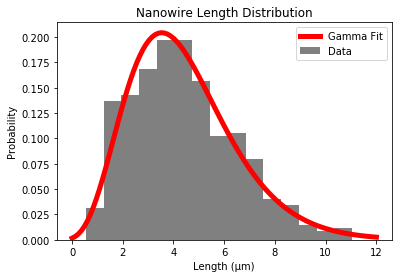

Gamma parameters (shape, location, scale): 5.771156286413882, -0.6547258078039633, 0.8783668307760546
Mean Length (µm): 4.41446


In [4]:
histogram = np.histogram(nanowire_lengths, bins=15, density=True)
fit_alpha, fit_loc, fit_beta = stats.gamma.fit(nanowire_lengths)
s, loc, scale = stats.lognorm.fit(nanowire_lengths)
gamma = stats.gamma(fit_alpha, fit_loc, fit_beta).pdf(np.linspace(0, 12, 100))
plt.bar(histogram[1][:-1], histogram[0], width=(histogram[1][1]-histogram[1][0]), align='edge', color='gray', label='Data')
plt.plot(np.linspace(0, 12, 100), gamma, linewidth=5, color='red', label='Gamma Fit')
plt.legend(); plt.title('Nanowire Length Distribution'); plt.xlabel('Length (µm)'); plt.ylabel('Probability'); plt.show()
print('Gamma parameters (shape, location, scale): {}, {}, {}'.format(fit_alpha, fit_loc, fit_beta))
print('Mean Length (µm): {}'.format(np.mean(nanowire_lengths)))

### Nanowire Density

As calculated below, there are approximately 0.23 nanowires per square micrometer of area.

In [5]:
density = np.mean(np.array(numbers_nanowires) / np.array(measurement_areas))
print('Mean Nanowire Density (nanowires / µm^2): {}'.format(density))

Mean Nanowire Density (nanowires / µm^2): 0.2304729758777117


---

# PHYSICAL NETWORK - AG@TiO$_2$

Also measure the properties of a titanium dioxide nanowire network with data provided by Li Qiao. Analysis of the image "network.jpg" in folder "tio2" with ImageJ gives the following measurements.

## Electrodes

Via analysis of "network.jpg", it was found the TiO$_2$ network is straddled by two electrodes, each 42 µm wide, 78 µm apart. Nanowires are placed inside a 55 by 108 µm rectangle centered on the electrodes.

## Nanowires

Further analysis of "network.jpg" gave the following measurements of nanowire length and density. 

In [6]:
nanowire_lengths = [ # lengths of assorted TiO2 nanowires in µm
5.87, 3.85, 4.23, 1.99, 5.49, 6.05, 8.61, 3.53, 3.88, 4.12, 3.07, 1.28, 2.66, 3.42, 4.21, 5.82, 5.82, 7.01, 4.05, 10.19,
5.66, 1.03, 1.84, 2.56, 4.44, 5.92, 6.62, 1.53, 4.93, 3.70, 2.66, 5.35, 2.72, 7.52, 10.41, 7.21, 3, 3.31, 2.76, 1.66,
3.71, 5.72, 3.04, 3.52, 9.78, 2.86, 5.09, 3.45, 3.87, 8.58, 2.82, 2.82, 4.61, 3.35, 3.23, 7.94, 6.95, 2.24, .87, 1.63,
3.46, 5.23, 9.07, 4.1, 3.19, 3.44, 5.97, 7.65, 3.93, 6.22, 6.8, 4.8, 3.02, 8.03, 5.72, 6.4, 5.46, 4.52, 6.4, 4.04,
4.22, 1.58, 4.25, 5.21, 2.23, 6.95, 4.57, 6.09, 6.09, 4.77, 6.07, 2.03, 1.92, 2.98, 3.62, 2.6, 2.14, 1.84, 6.11, 4.68,
4.88, 4.89, 8.06, 3.66, 1.73, 1.6, 4.18, 6.37, 7.48, 4.74, 6.55, 3.23, 3.77, 6.14, 9.95, 6.78, 9.21, 5.28, 11.65, 3.18,
4.79, 3.23, 4.58, 9.96, 2.47, 11.8, 5.52, 2.66, 2.96, 6.3, 8.57, 10.47, 11.95, 9.44, 11.83, 5.39, 3.33, 5.5, 2.84, 11.36,
6.72, 12.72, 10.65, 7.56, 2.17, 8.19, 8.33, 6.03, 6.1, 5.92, 4.74, 3.82, 5.33, 3.21, 4.73, 5.62, 2.11, 5.43, 7.72, 3.37,
3, 8.9, 3.49, 1.52, 4.07, 7.38, 8.62, 8.4, 5.41, 6.31, 7.03, 11.65, 6.53, 4.07, 2.62, 8.39, 4.49, 3.48, 4.86, 3.4,
6.39, 4.82, 8.36, 5.03, 10.42, 5.25, 5.11, 6.22, 6.56, 4.59, 4.83, 12.4, 10.5, 7.49, 6.11, 4.12, 8.33, 3.39, 2.33, 5.61,
3.33, 3.42, 4.37, 3.88, 7.91, 12.01, 7.6, 4.62, 3.19, 7.14, 4.25, 2.72, 6.76, 3.68, 2.88, 2.55, 3.51, 3.61, 1.15, 2.38,
3.4, 3.12, 3.01, 9.96, 5.76, 3.13, 3.87, 6.65, 5.29, 4.98, 2.78, 6.86, 6.76, 7.53, 3.96, 4.69, 3.63, 5.96, 5.75, 3.99,
6.02, 7.41, 3.04, 2.27, 3.21, 4.03, 4.61, 7.16, 4.45, 6.03, 4.76, 7.22, 8.61, 6.15, 5.75, 5.76, 4.49, 8.35, 8.53, 2.49,
3.31, 6.95, 7.78, 6.33, 4.69, 6.61, 3.6, 2.15, 1.87, 2.96, 5.97, 6.84, 3.56, 4.81, 4.14, 3.18, 2.5, 5.78, 3.14, 4.29,
7.28, 3.89, 5.24, 9.11, 3.73, 2.28, 6.91, 5, 4.1, 6.47, 7.94, 14.32, 12.83, 11.08, 8.15, 10.06, 9.14, 8.04, 8.55, 10.13,
1.23, 6.37, 2.90, 2.63, 7.72, 8.7, 4.19, 6.1, 8.91, 9.32, 10.18, 9.32, 2.7, 7.61, 5.28, 2.2, 4.32, 7.25, 4.68, 4.41,
7.72, 5.21, 6.46, 5.06, 3.46, 6.48, 5.26, 2.82, 7.33, 4.4, 7.57, 9.36, 6.24, 5.3, 3.33, 2.44, 5.05, 3.76, 7.57, 4.41,
7.1, 6.1, 6.16, 5.36, 10.14, 8.89, 7.42, 6.23, 3.65, 7.03, 5.20, 2.42, 2.96, 9.06, 4.48, 11.63, 7.07, 9.03, 1.14, 12.85,
9.85, 7.19, 3.56, 1.47, 2.19, 7.3, 4.59, 5.52, 6.48, 3.63, 4.85, 5.94, 3.27, 4.25, 2.89, 6.88, 12.77, 9.49, 7.70, 6.43,
10.63, 3.77, 4.04, 1.71, 7.16, 3.38, 4.13, 8.07, 10.89, 9.4, 5.53, 6.02, 6.22, 8.1, 6.17, 8.68, 2.58, 2.22, 8.93, 4.44,
4.17, 10.47, 4.12, 9.72, 5.09, 3.84, 13.5, 9.81, 6.99, 4.52, 4.61, 2.57, 1.61, 1.33, 11.04, 3.87, 4.09, 4, 2.14, 4.15,
11.23, 7.66, 5.81, 9.36, 2.96, 6.91, 8.21, 3.11, 6.92, 2.88, 1.7, 5.22, 6.07, 2.1, 3.81, 2.71, 3.1, 4.42, 5.45, 3.92,
6.44, 3.48, 8.76, 10.6, 5.1, 5.77, 2.72, 1.55, 3.13, 6.63, 7.35, 3.17, 5.76, 4.53, 3.44, 2.64, 5.49, 2.2, 2.75, 3.59,
5.2, 4.73, 9.13, 4.23, 2.71, 4.91, 5.4, 4.74, 8.68, 3.51, 7.73, 8.6, 3.54, 8.32, 2.66, 10.11, 5.63, 6.05, 4.86, 3.29,
5.6, 2.72, 7.21, 5.27, 5.88, 5.89, 3.17, 5.11, 5.49, 8.24, 5.91, 13.14, 2.99, 4.62, 11.04, 5.9, 5.39, 2.03, 1.55, 2.47]

In [9]:
# numbers of nanowires in assorted areas (measured in µm^2)
measurement_areas = [655, 690, 613, 776, 521, 605, 557, 629, 527, 804, 597, 889]
numbers_nanowires = [93, 97, 88, 96, 76, 69, 91, 87, 94, 112, 57, 111]

### Nanowire Length

As shown below, the nanowires vary widely in length around 5.5 µm with a distribution that skews right. For simulation purposes, this can be approximated by a gamma distribution with Python's shape/location/scale parameters of 3.67, 0.34, 1.40.

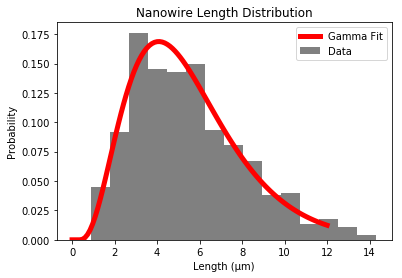

Gamma parameters (shape, location, scale): 3.6665738311054077, 0.337275272221315, 1.4038003737466445
Mean Length (µm): 5.48442


In [7]:
histogram = np.histogram(nanowire_lengths, bins=15, density=True)
fit_alpha, fit_loc, fit_beta = stats.gamma.fit(nanowire_lengths)
s, loc, scale = stats.lognorm.fit(nanowire_lengths)
gamma = stats.gamma(fit_alpha, fit_loc, fit_beta).pdf(np.linspace(0, 12, 100))
plt.bar(histogram[1][:-1], histogram[0], width=(histogram[1][1]-histogram[1][0]), align='edge', color='gray', label='Data')
plt.plot(np.linspace(0, 12, 100), gamma, linewidth=5, color='red', label='Gamma Fit')
plt.legend(); plt.title('Nanowire Length Distribution'); plt.xlabel('Length (µm)'); plt.ylabel('Probability'); plt.show()
print('Gamma parameters (shape, location, scale): {}, {}, {}'.format(fit_alpha, fit_loc, fit_beta))
print('Mean Length (µm): {}'.format(np.mean(nanowire_lengths)))

### Nanowire Density

As calculated below, there are approximately 0.23 nanowires per square micrometer of area.

In [10]:
density = np.mean(np.array(numbers_nanowires) / np.array(measurement_areas))
print('Mean Nanowire Density (nanowires / µm^2): {}'.format(density))

Mean Nanowire Density (nanowires / µm^2): 0.13745444703391843


---

# NETWORK CONNECTIVITY

Next, we will determine properties of the network based on the above estimated parameters.

According to said parameters, the nanowires occupy a square area about 3000 µm wide on a side. This would contain about two million nanowires. Because this would be difficult to simulate in a reasonable timeframe, consider instead a 30 µm wide square area with a total of about 200 nanowires.


### Scaling Behaviors

As shown below, as the number of nanowires in a given area increases, the total number of junctions increases quadratically while the number of junctions per nanowire increases linearly.

This is straightforward in theory: consider any two nanowires. Because they are independently, randomly, and uniformly positioned, there is some constant (albeit hard to calculate) (proportional to the nanowire length squared) probability they will touch to form a junction. Thus, the number of junctions should be proportional to the number of pairs of nanowires, which, for a number of nanowires $N$, is

$$\frac{N^2-N}{2}.$$

For large $N$, $N^2\gg N$, so this means the number of junctions $J$ has, approximately, $J\propto N^2$.

Divide the total number of junctions by the number of nanowires to find that the number of junctions per nanowire, $J_n$, has about $J_n\propto N$.

In [11]:
# assume some experiment constants
e_size = 5 # um, electrode size
area_size = 30; area = area_size**2 # um

# create arrays to hold results
nw_density = []; j_density = []; j_per_n = []; percent_nw_connected = []; not_connected = []

# iterate through nanowire densities
min_density = 0.01; max_density = 0.4; density_step = .001
current_density = min_density
bar = FloatProgress(min=min_density, max=max_density); display(bar) # progress bar!
while current_density < max_density:
    
    # create a random network with the given nanowire density
    network = create_network(params={
        'width':area_size, 'height':area_size,
        'inputs':1, 'outputs':1,
        'e_width':e_size, 'e_height':e_size,
        'density':current_density,
        'lalpha':5.77, 'lloc':-0.65, 'lbeta':0.87,
        'seed':random.randint(0,1e6)
    })
    
    # store values
    nw_density.append(current_density)
    j_density.append(len(network['junctions'])/area_size)
    j_per_n.append(np.mean([len(n['junctions']) for n in network['nanowires']]))
    percent_nw_connected.append(len([n for n in network['nanowires'] if n['connected']])/len(network['nanowires'])*100)
    
    # update density and progress bar
    current_density += density_step
    bar.value = current_density

FloatProgress(value=0.01, max=0.4, min=0.01)

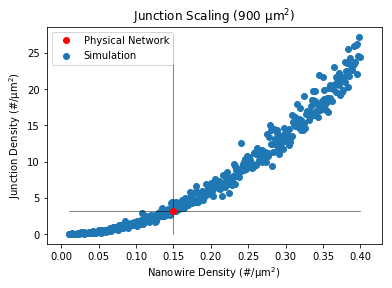

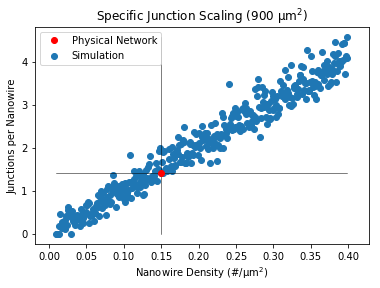

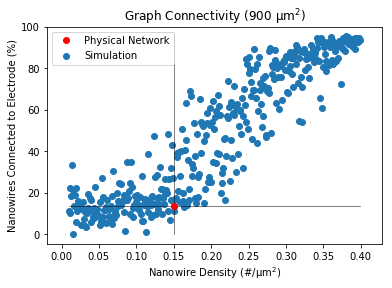

In [12]:
density = 0.15 # mark this density
nw_density = np.array(nw_density)
poi = np.argmin(np.abs(nw_density-density))
plt.scatter(nw_density, j_density, label='Simulation')
plt.plot(nw_density, np.zeros(len(nw_density))+j_density[poi], color='black', linewidth=0.5)
plt.plot(np.zeros(2)+nw_density[poi], np.linspace(0, np.max(j_density), 2), color='black', linewidth=0.5)
plt.plot(nw_density[poi], j_density[poi], 'ro', label='Physical Network')
plt.xlabel('Nanowire Density (#/µm$^2$)'); plt.ylabel('Junction Density (#/µm$^2$)'); plt.title('Junction Scaling (900 µm$^2$)')
plt.legend(); plt.show()
plt.scatter(nw_density, j_per_n, label='Simulation')
plt.plot(nw_density, np.zeros(len(nw_density))+j_per_n[poi], color='black', linewidth=0.5)
plt.plot(np.zeros(2)+nw_density[poi], np.linspace(0, np.max(j_per_n), 2), color='black', linewidth=0.5)
plt.plot(nw_density[poi], j_per_n[poi], 'ro', label='Physical Network')
plt.xlabel('Nanowire Density (#/µm$^2$)'); plt.ylabel('Junctions per Nanowire'); plt.title('Specific Junction Scaling (900 µm$^2)$')
plt.legend(); plt.show()
plt.scatter(nw_density, percent_nw_connected, label='Simulation')
plt.plot(nw_density, np.zeros(len(nw_density))+percent_nw_connected[poi], color='black', linewidth=0.5)
plt.plot(np.zeros(2)+nw_density[poi], np.linspace(0, np.max(percent_nw_connected), 2), color='black', linewidth=0.5)
plt.plot(nw_density[poi], percent_nw_connected[poi], 'ro', label='Physical Network')
plt.xlabel('Nanowire Density (#/µm$^2$)'); plt.ylabel('Nanowires Connected to Electrode (%)'); plt.title('Graph Connectivity (900 µm$^2)$')
plt.legend(); plt.show()

### Connectivity

As also shown above, surprisingly often, a large fraction of the nanowires are not connected to the electrodes. See below for an example.

Via the graphs above and below, it seems connectivity (for this particular distribution of nanowire lengths) occurs around 0.25 nanowires per square micrometer. Surprisingly, this seems to be independent of sample area. However, it is correlated with nanowire length. Increasing mean length from 4.5 to 5.5 micrometers decreased the density to 0.2.

One can attempt to model this. Consider the probability of two randomly placed nanowires of length $L$ in a fixed space intersecting. Approximate this by the bounding circle of the nanowires. These bounding circles intersect in the area of the circle of radius $2L$, which has area $\propto L^2$. So for any area $A$, the density of nanowires $D$ will give $N$ nanowires. As derived above, the number of junctions is proportional to $N^2$ and, now, $L^2$, so the number of junctions per nanowire is proportional to $N\cdot L^2$, or, equivalently, $D\cdot L^2$. Suppose that a given graph is connected when the average number of junctions per nanowire is around some constant, say, $4$. Then the graph is connected at a point governed by $D\cdot L^2$.

Furthermore, the total area seems to have little bearing on this number: a wider area with the same nanowire density will have a greater connectivity, while a longer area will have less. Assuming square aspect ratios, assume these cancel out.

So, in order to increase graph connectivity, increase nanowire length and density according to $D\cdot L^2$. (note: a small test gives the approximate empirical result $D\cdot L^{1.5}$) 

An example graph of the PVP nanowire conditions follows.

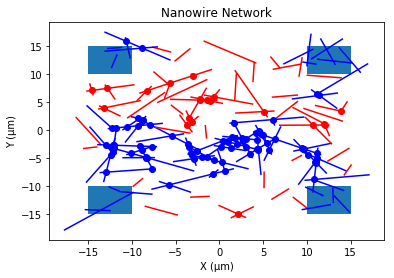

Nanowires connected to electrodes: 56%


In [13]:
network = create_network(params={
    'width':30, 'height':30,
    'inputs':2, 'outputs':2,
    'e_width':5, 'e_height':5,
    'density':0.14,
    'lalpha':5.77, 'lloc':-0.65, 'lbeta':0.87,
    'seed':0
})
plot_network(network, show_junctions=True)
print("Nanowires connected to electrodes: {}%".format(round(len([n for n in network['nanowires'] if n['connected']])/len(network['nanowires'])*100)))

Here is a similar result for a larger TiO$_2$ nanowire mesh. In this case, the measured density, about 0.14 nanowires per square micrometer, results in very low connectivity. A higher density of 0.25 or so fixes this.

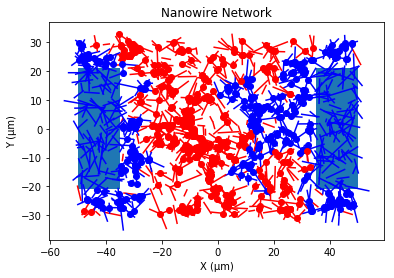

Nanowires connected to electrodes: 53%


In [14]:
network = create_network(params={
    'width':100, 'height':60,
    'inputs':1, 'outputs':1,
    'e_width':15, 'e_height':42,
    'density':0.14,
    'lalpha':3.67, 'lloc':.34, 'lbeta':1.4,
    'seed':0
})
plot_network(network, show_junctions=True)
print("Nanowires connected to electrodes: {}%".format(round(len([n for n in network['nanowires'] if n['connected']])/len(network['nanowires'])*100)))

---

# NETWORK TIME RESPONSE

The network might be most interesting when considered as a dynamic whole. First create a simple network.

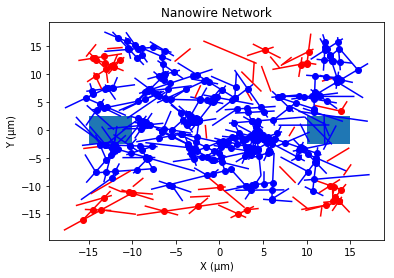

Nanowires connected to electrodes: 73%


In [15]:
network = create_network(params={
    'width':30, 'height':30,
    'inputs':1, 'outputs':1,
    'e_width':5, 'e_height':5,
    'density':0.28, # for about 250 nanowires total
    'lalpha':5.77, 'lloc':-0.65, 'lbeta':0.88,
    'seed':0
})

plot_network(network, show_junctions=True, save='simnet.svg')
print("Nanowires connected to electrodes: {}%".format(round(len([n for n in network['nanowires'] if n['connected']])/len(network['nanowires'])*100)))

Now, simulate this network with a constant voltage.

In [16]:
def voltage_func(time, index):
    voltages = [0,.1]
    return voltages[index]
   
# use random number in data variable so it isn't written over by other simulations
data492 = simulate(params={
    'network':network,
    'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
    'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
    'noise_sigma':0.1,
    'dissolution_time':10,
    'voltage_function':voltage_func,
    'max_current':1,
    'max_current_accuracy':0.05,
    'timestep':0.01, 'total_time':10,
    'seed':0
})

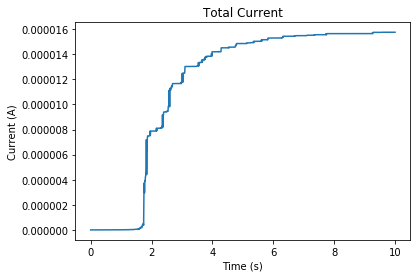

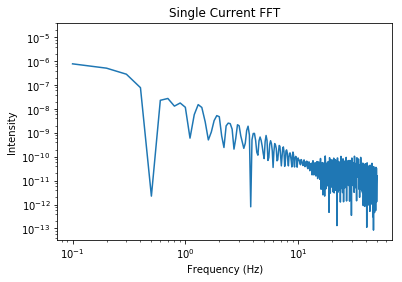

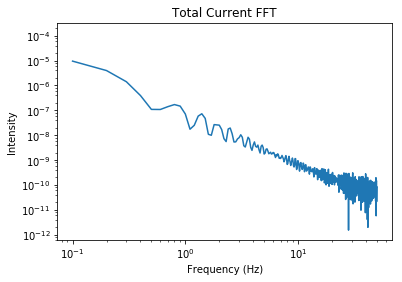

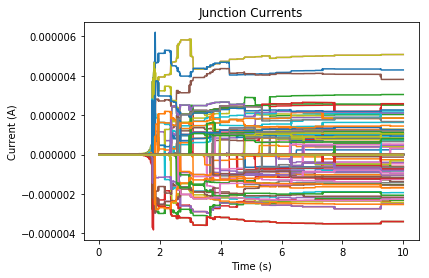

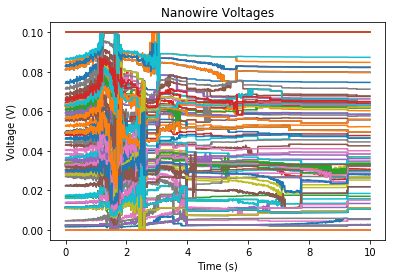

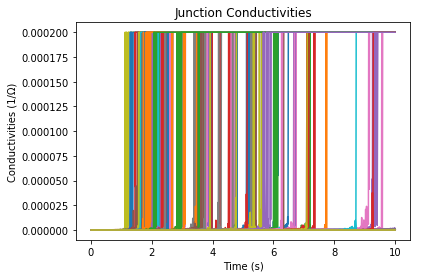

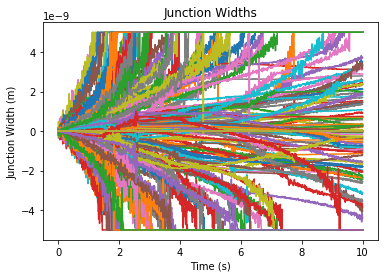

In [17]:
times = data492['times']
currents = data492['currents']
widths = data492['widths']
voltages = data492['voltages']
conductivities = data492['conductivities']
tcurrents = data492['tcurrents']

def plotfft(data, timestep, title, save):
    freqpoints = np.linspace(0, 1/(2*timestep), math.ceil(len(data)/2))
    fft = (np.abs(np.fft.fft(data))**2)[0:len(freqpoints)]
    plt.loglog(freqpoints, fft);
    plt.xlabel('Frequency (Hz)'); plt.ylabel('Intensity'); plt.title(title); 
    plt.savefig(save, bbox_inches='tight');
    plt.show()
    
    
cutoff=0
plt.plot(times[cutoff:], np.array(tcurrents)[cutoff:,1]); plt.title('Total Current'); plt.xlabel('Time (s)'); plt.ylabel('Current (A)'); plt.savefig('tcurrents.svg', bbox_inches='tight'); plt.show()
plotfft(np.array(currents)[cutoff:,6], times[1]-times[0], 'Single Current FFT', 'spsd.svg')
plotfft(np.array(tcurrents)[cutoff:,0], times[1]-times[0], 'Total Current FFT', 'tpsd.svg')
plt.plot(times, currents); plt.title('Junction Currents'); plt.xlabel('Time (s)'); plt.ylabel('Current (A)');plt.savefig('currents.svg', bbox_inches='tight'); plt.show()
plt.plot(times, voltages); plt.title('Nanowire Voltages'); plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)');plt.savefig('voltages.svg', bbox_inches='tight'); plt.show()
plt.plot(times, conductivities); plt.title('Junction Conductivities'); plt.xlabel('Time (s)'); plt.ylabel('Conductivities (1/Ω)');plt.savefig('conductances.svg', bbox_inches='tight'); plt.show()
plt.plot(times, widths); plt.title('Junction Widths'); plt.xlabel('Time (s)'); plt.ylabel('Junction Width (m)');plt.savefig('widths.svg', bbox_inches='tight'); plt.show()


## Time Response Commentary

This result is very typical of this network. Consider a single junction. Governed by its width under the differential equation

$$\frac{dw}{dt} = \mu_v \cdot \frac{R_{on}}{w_{max}}\cdot|I|-\frac{w}{\tau},$$

where $w$ is the junction width, $t$ is time, $R_{on}$ and $R_{off}$ are the junction resistances at width 0 and width $w_{max}$, respectively, $V$ and $I$ are voltage and current across the junction, and $\tau$ is a time constant. If one assumes there is no current through the junction, then the junction width decays exponentially with time constant $\tau$. Its half life is

$$\ln(2)\cdot\tau\approx0.693\tau.$$

On the other hand, if one assumes a constant voltage and no time decay, the junction width rises according to a sort of inverted square root law as

$$w(t)=\frac{R_{on}}{R_{off}-R_{on}}\cdot w_{max}-\sqrt{-\frac{2\mu_v\cdot R_{on}\cdot V}{R_{off}-R_{on}}\cdot t},$$

which has "half-life"

$$\frac{R_{off}\cdot {w_{max}^2}}{8\cdot\mu_v\cdot R_{on}\cdot V}.$$

You can see these curves in the junction widths graph above. Widths either increase according to the square-root-esque law, decrease exponentially, or a combination of both as the currents coursing through them change.

There is interesting emergent behavior: the total current seems to rise exponentially.

Finally, keep in mind that the conductivity of a junction varies widely between on and off states at different junction widths:

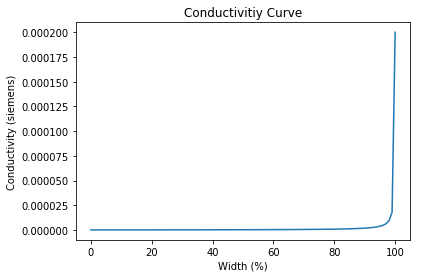

In [19]:
widths = []
conductivities = []
for width in np.linspace(0, 1, 100):
    widths.append(width*100)
    conductivities.append(1/(5e3*width + 5e6*(1-width)))
plt.plot(widths, conductivities)
plt.xlabel('Width (%)'); plt.ylabel('Conductivity (siemens)'); plt.title('Conductivitiy Curve'); plt.show()

---

# More Simulations

For completeness, here is a table of the same curves computed for different time constants in parallel via Amazon. To run this code, you will have to install pywren and conigure it with an Amazon AWS account (see below). However, Jupyter stores precomputed figures, so this is not necessary.

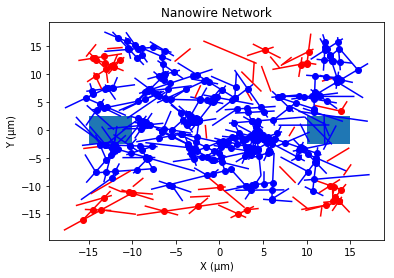

Nanowires connected to electrodes: 73%


In [110]:
network231 = create_network(params={
    'width':30, 'height':30,
    'inputs':1, 'outputs':1,
    'e_width':5, 'e_height':5,
    'density':0.28, # for about 250 nanowires total
    'lalpha':5.77, 'lloc':-0.65, 'lbeta':0.88,
    'seed':0
})

plot_network(network231, show_junctions=True)
print("Nanowires connected to electrodes: {}%".format(round(len([n for n in network231['nanowires'] if n['connected']])/len(network231['nanowires'])*100)))

In [114]:
def voltage_func(time, index):
    voltages = [0,.1]
    return voltages[index]

def simulate_time(dissolution_time):
    data = simulate(params={
        'network':network231,
        'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
        'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
        'noise_sigma':0.1,
        'dissolution_time':dissolution_time,
        'voltage_function':voltage_func,
        'max_current':1,
        'max_current_accuracy':0.05,
        'timestep':0.01, 'total_time':20,
        'seed':0
    })
    # cannot return data directly for some arcane reason
    return {'times':data['times'], 'currents':data['currents'],
            'widths':data['widths'], 'voltages':data['voltages'],
            'conductivities':data['conductivities'],
            'tcurrents':data['tcurrents'], 'dtime':dissolution_time}

wrenexec = pywren.default_executor()
futures = wrenexec.map(simulate_time, np.linspace(.1, 2.5, 10))
alldata019 = pywren.get_all_results(futures)

========== Decay Time Constant: 0.1 / Voltage: 0.1 ==========


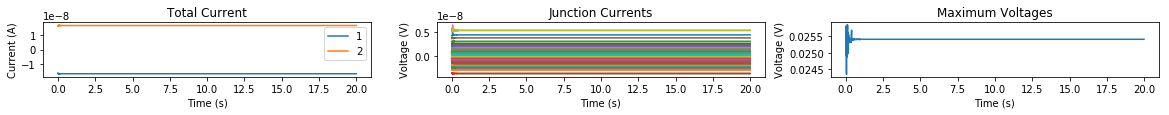

========== Decay Time Constant: 0.3666666666666667 / Voltage: 0.1 ==========


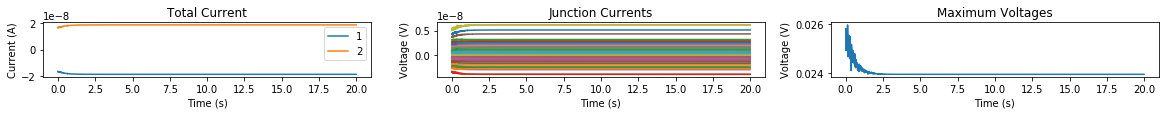

========== Decay Time Constant: 0.6333333333333333 / Voltage: 0.1 ==========


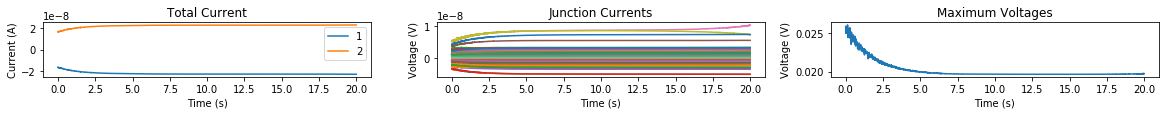

========== Decay Time Constant: 0.9 / Voltage: 0.1 ==========


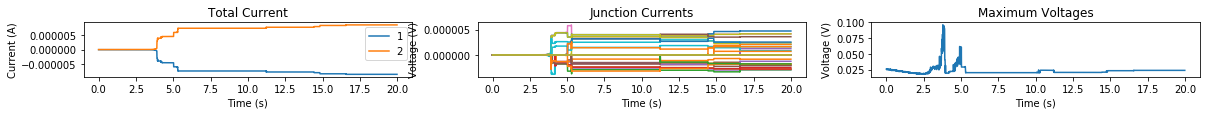

========== Decay Time Constant: 1.1666666666666667 / Voltage: 0.1 ==========


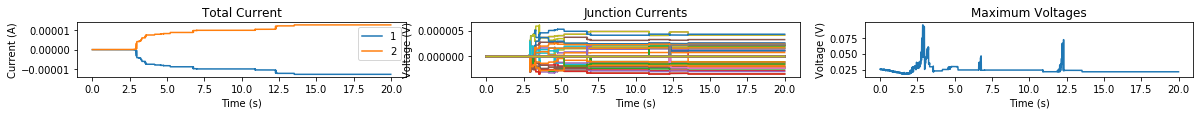

========== Decay Time Constant: 1.4333333333333333 / Voltage: 0.1 ==========


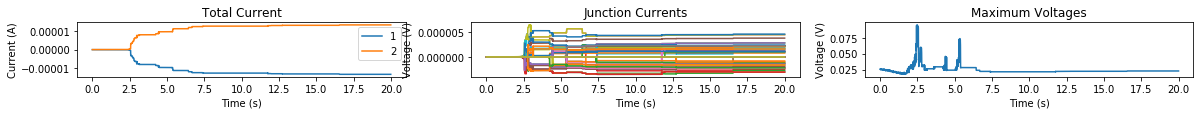

========== Decay Time Constant: 1.7000000000000002 / Voltage: 0.1 ==========


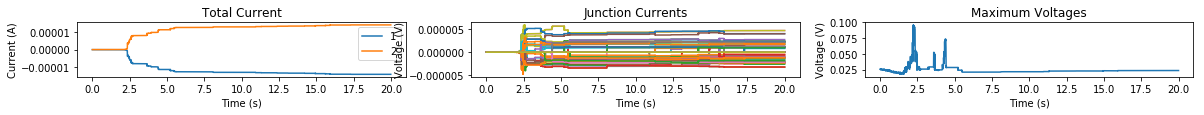

========== Decay Time Constant: 1.9666666666666668 / Voltage: 0.1 ==========


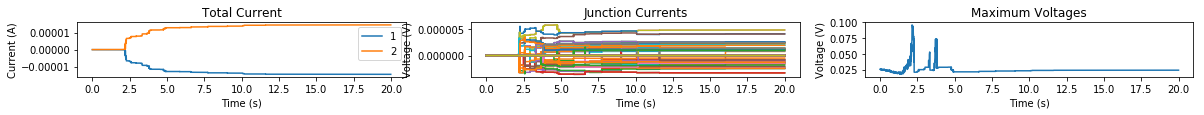

========== Decay Time Constant: 2.2333333333333334 / Voltage: 0.1 ==========


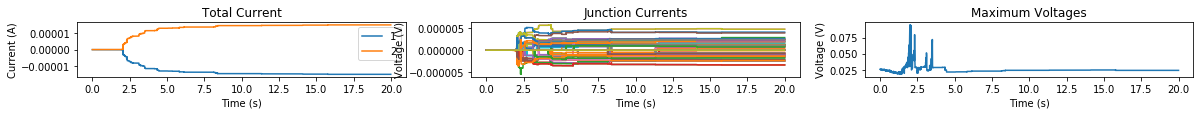

========== Decay Time Constant: 2.5 / Voltage: 0.1 ==========


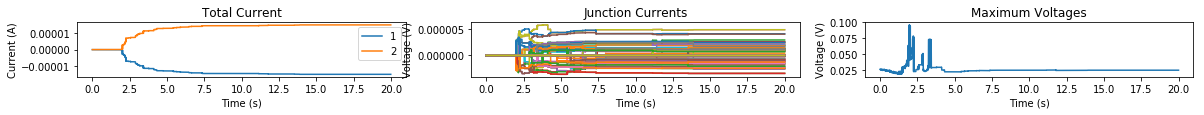

In [116]:
for data in alldata019:
    times = np.array(data['times'])
    currents = np.array(data['currents'])
    widths = np.array(data['widths'])
    voltages = np.array(data['voltages'])
    conductivities = np.array(data['conductivities'])
    tcurrents = np.array(data['tcurrents'])
    
    def plotfft(data, timestep, title):
        freqpoints = np.linspace(0, 1/(2*timestep), math.ceil(len(data)/2))
        fft = (np.abs(np.fft.fft(data))**2)[0:len(freqpoints)]
        plt.loglog(freqpoints, fft);
        plt.xlabel('Frequency (Hz)'); plt.ylabel('Intensity'); plt.title(title); plt.show()
   
    maxvoltages = np.abs(currents / conductivities).max(axis=1)
    
    print('========== Decay Time Constant: {} / Voltage: {} =========='.format(data['dtime'], 0.1))

    cutoff = 0 
    plt.figure(figsize=(20,1))
    plt.subplot(131)
    plt.plot(times[cutoff:], tcurrents[cutoff:,0], label='1');
    plt.plot(times[cutoff:], tcurrents[cutoff:,1], label='2'); plt.legend(); plt.title('Total Current'); plt.xlabel('Time (s)'); plt.ylabel('Current (A)');
    plt.subplot(132)
    plt.plot(times, currents); plt.title('Junction Currents'); plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)');
    plt.subplot(133)
    plt.plot(times, maxvoltages); plt.title('Maximum Voltages'); plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)'); plt.show()

---

# Finite State Machine Computing

So, suppose one wants to use this kind of resistive network for computing, where inputs are changes to the electrode voltages over time and outputs are the currents through electrodes. It's a pretty limited setup (resistances only), but it turns out that, if one can limit the current through any electrode, one can take advantage of the average memristance to make a finite state machine.

A [finite state machine](https://en.wikipedia.org/wiki/Finite-state_machine) (FSM) is a computer science model of a machine that switches between a number of states based on inputs. For example, a toggle switch changes state when you press it, or a vending machine changes the price required when different items are selected. These aren't very "powerful"---that is, they cannot compute complex, branching recursive statements like a full Turing machine (e.g., a typical laptop computer), but can still, say, add binary numbers, if built in the right way.

Consider the "state" of a nanowire network FSM as the set of low-resistance pathways between electrodes and voltages currently applied to electrodes. If the voltages change (an input), then the pathways might change, resulting in a change in current (which can be measured to detect the current state as a form of output).

Here's a proof-of-concept. Consider three electrodes: two "inputs" and one "output", with the output between the two inputs (to make two clearly-defined paths, each between the output and one input). One can switch the state of the network so that when the voltage pattern "010" is applied to the electrodes (that is, the two inputs are at 0 V and output is at 1 V), current will flow between either the output and the first input or between the output and the second input, not from the output to both, as one would expect. This relies on current limiting: if the current is limited so there is enough current for one path to stay conductive but not enough to stop the continuous decay of the other path, the steady state is assymetric.

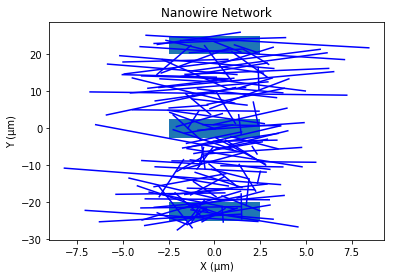

In [115]:
network431 = create_network(params={
    'width':5, 'height':50,
    'inputs':2, 'outputs':1,
    'e_width':5, 'e_height':5,
    'density':.5,
    'lalpha':6, 'lloc':0, 'lbeta':1,
    'seed':1
})

plot_network(network431)

Note the graph of the network is scaled differently in the X and Y directions.

Now, apply a sequence of four voltage patterns to the electrodes. Note the currents through the electrodes. Note only one "INA" and "INB" electrodes receives significant current at any time. In particular, the currents in 2-4 and 6-8 second periods are different despite identical voltages.

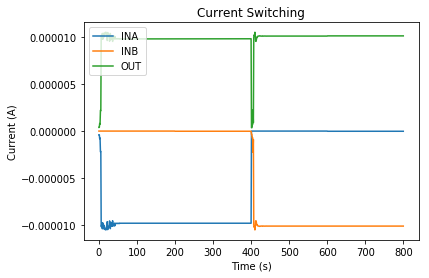

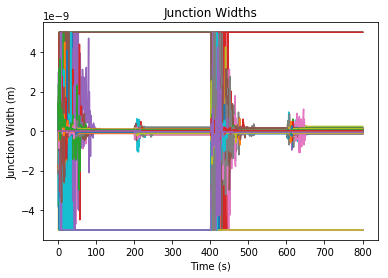

In [112]:
def voltage_func862(time, index):
    voltages = [0,0,0]
    if time < 2:
        voltages = [0,1,1]
    elif time < 4:
        voltages = [0,0,1]
    elif time < 6:
        voltages = [1,0,1]
    else:
        voltages = [0,0,1]
    return voltages[index]
   
data868 = simulate(params={
    'network':network431,
    'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
    'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
    'noise_sigma':0.1,
    'dissolution_time':.1,
    'voltage_function':voltage_func862,
    'max_current':.00001, # IMPORTANT
    'max_current_accuracy':0.05,
    'timestep':0.01, 'total_time':8,
    'seed':0
})

plt.plot(np.array(data868['tcurrents'])[:,0], label='INA')
plt.plot(np.array(data868['tcurrents'])[:,1], label='INB')
plt.plot(np.array(data868['tcurrents'])[:,2], label='OUT')
plt.xlabel('Time (s)'); plt.ylabel('Current (A)'); plt.legend();
plt.title('Current Switching'); plt.show()
plt.plot(data868['widths']); plt.xlabel('Time (s)'),
plt.ylabel('Junction Width (m)'); plt.title('Junction Widths'); plt.show()

It is probably difficult (but perhaps possible) to make more complex FSMs: one needs to create certain electrode arrangements and voltage input patterns.

---

# Decay Time Measurement

Consider how one would experimentally measure the decay time of a network.

The naive method is to, during the process of decay, measure its resistance periodically. If the current is small enough to only negligibly affect the network, this would give the following curve, assuming the width decreases exponentially (A more complex, potentially more accurate, but much slower method is to run current through a network to form a conductive path, wait a time, then do so again, recording the time difference (which represents the filament formation not yet decayed. Repeat many times. Very difficult when decay constant is large (as is the case here)):

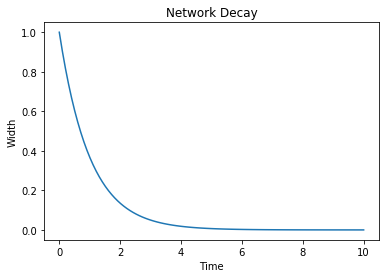

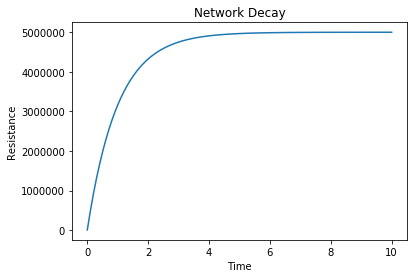

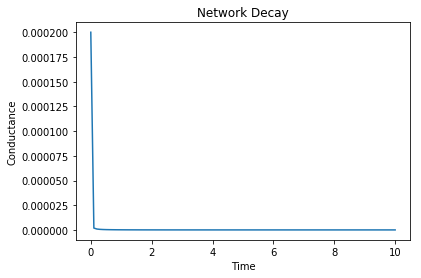

In [7]:
ron = 5e3; roff = 5e6
times = []
widths = []
rs = []
cs = []
for time in np.linspace(0, 10, 100):
    times.append(time)
    width = math.exp(-time) # between 0 and 1
    widths.append(width)
    r = width*ron + (1-width)*roff
    rs.append(r)
    cs.append(1/r)
    
plt.plot(times, widths); plt.xlabel('Time'); plt.ylabel('Width'); plt.title('Network Decay'); plt.show()
plt.plot(times, rs); plt.xlabel('Time'); plt.ylabel('Resistance'); plt.title('Network Decay'); plt.show()
plt.plot(times, cs); plt.xlabel('Time'); plt.ylabel('Conductance'); plt.title('Network Decay'); plt.show()
    

---

# pywren

One can run these simulations in parallel on Amazon's AWS Lambda service for next to nothing (single ¥). The easiest way to do so is to use the pywren library. Unfortunately, it has proved very difficult to successfully install and set up (including linking to an AWS account) pywren on Windows (it is much easier on Linux). To test the pywren library, use the following code.

In [21]:
def testf(n):
    return n**2

wrenexec = pywren.default_executor()
futures = wrenexec.map(testf, [1,2,3])
print(pywren.get_all_results(futures))

[1, 4, 9]


The following code blocks create and simulate a 5-electrode network using AWS.

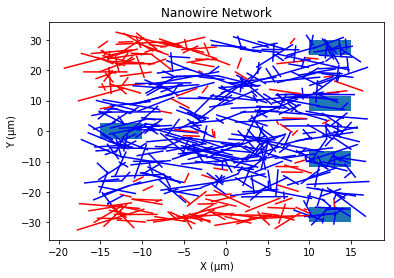

Nanowires connected to electrodes: 72%


In [14]:
network231 = create_network(params={
    'width':30, 'height':60,
    'inputs':1, 'outputs':4,
    'e_width':5, 'e_height':5,
    'density':0.3, # for about 250 nanowires total
    'lalpha':5.77, 'lloc':-0.65, 'lbeta':0.88,
    'seed':0
})

plot_network(network231, show_junctions=False)
print("Nanowires connected to electrodes: {}%".format(round(len([n for n in network231['nanowires'] if n['connected']])/len(network231['nanowires'])*100)))

In [15]:
def voltage_func(time, index):
    voltages = [.1,0,0,0,0]
    return voltages[index]

def simulate_time(dissolution_time):
    data = simulate(params={
        'network':network231,
        'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
        'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
        'noise_sigma':0,
        'dissolution_time':dissolution_time,
        'voltage_function':voltage_func,
        'max_current':1,
        'max_current_accuracy':0.05,
        'timestep':0.01, 'total_time':20,
        'seed':0
    })
    # cannot return data directly for some arcane reason
    return {'times':data['times'], 'currents':data['currents'],
            'widths':data['widths'], 'voltages':data['voltages'],
            'conductivities':data['conductivities'],
            'tcurrents':data['tcurrents'], 'dtime':dissolution_time}

wrenexec = pywren.default_executor()
futures = wrenexec.map(simulate_time, np.linspace(.1, 2.5, 10))
alldata019 = pywren.get_all_results(futures)



In [23]:
data = simulate(params={
    'network':network231,
    'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
    'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
    'noise_sigma':0,
    'dissolution_time':10,
    'voltage_function':voltage_func,
    'max_current':1,
    'max_current_accuracy':0.05,
    'timestep':0.01, 'total_time':20,
    'seed':0
})

========== Decay Time Constant: 0.1 / Voltage: 0.1 ==========


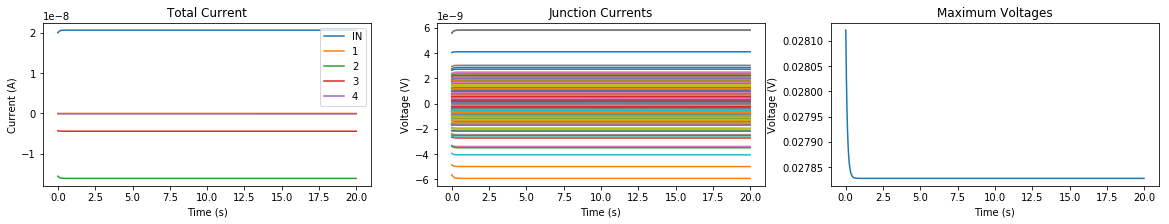

========== Decay Time Constant: 0.3666666666666667 / Voltage: 0.1 ==========


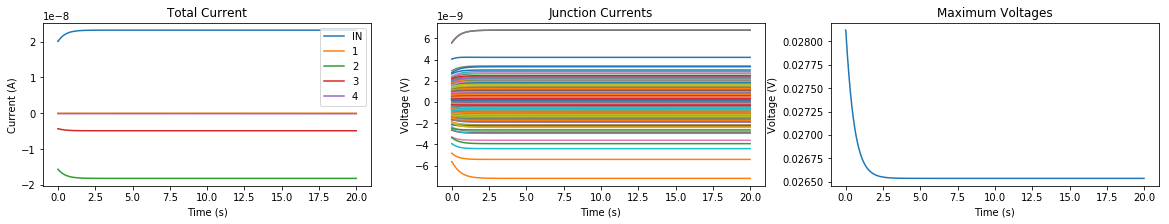

========== Decay Time Constant: 0.6333333333333333 / Voltage: 0.1 ==========


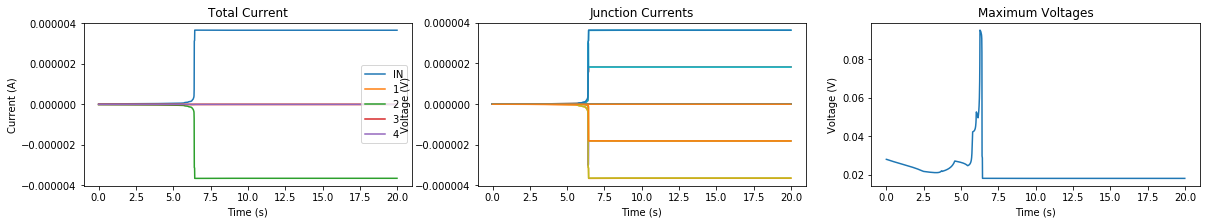

========== Decay Time Constant: 0.9 / Voltage: 0.1 ==========


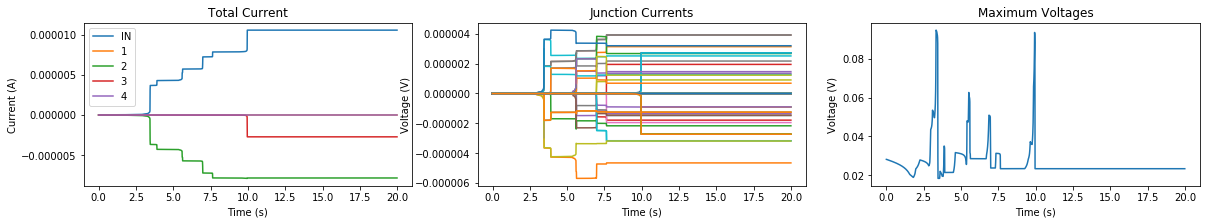

========== Decay Time Constant: 1.1666666666666667 / Voltage: 0.1 ==========


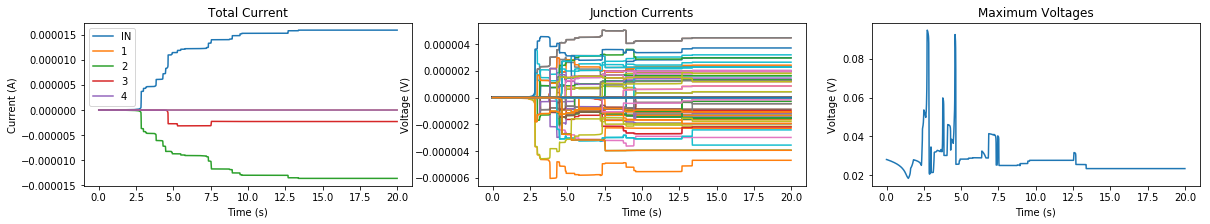

========== Decay Time Constant: 1.4333333333333333 / Voltage: 0.1 ==========


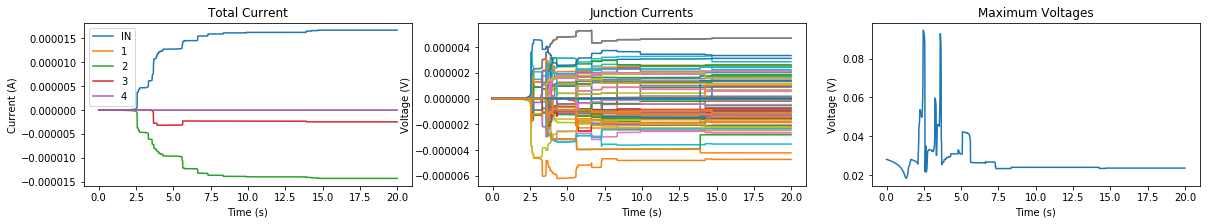

========== Decay Time Constant: 1.7000000000000002 / Voltage: 0.1 ==========


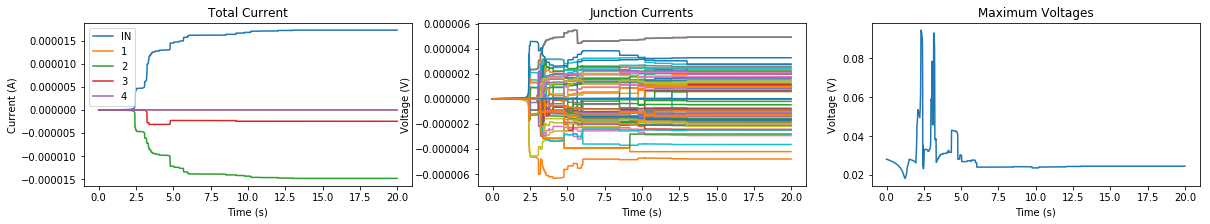

========== Decay Time Constant: 1.9666666666666668 / Voltage: 0.1 ==========


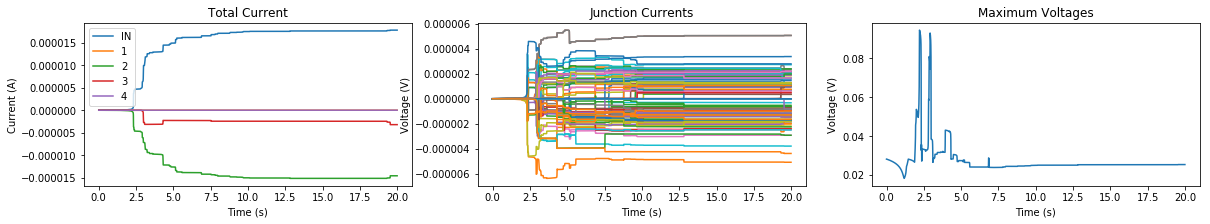

========== Decay Time Constant: 2.2333333333333334 / Voltage: 0.1 ==========


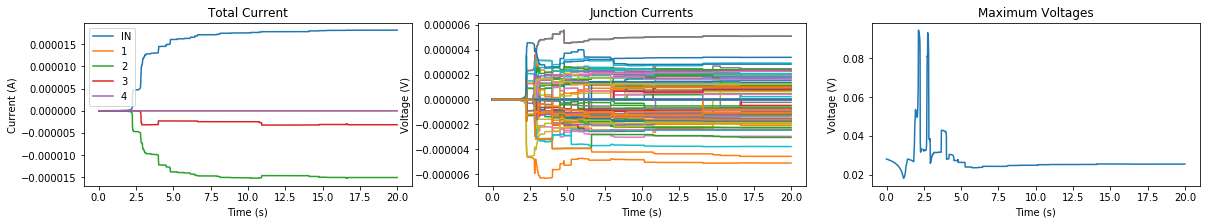

========== Decay Time Constant: 2.5 / Voltage: 0.1 ==========


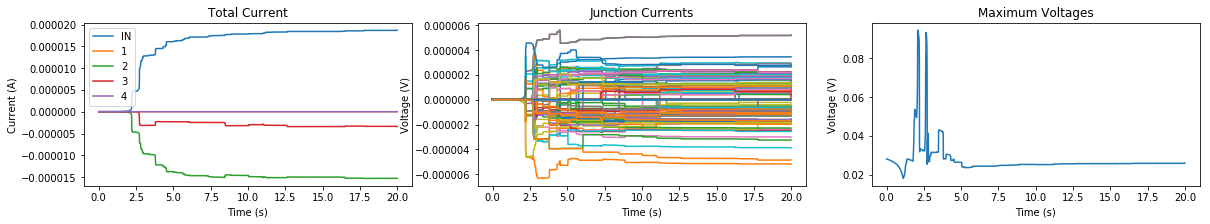

In [20]:
for data in alldata019:
    times = np.array(data['times'])
    currents = np.array(data['currents'])
    widths = np.array(data['widths'])
    voltages = np.array(data['voltages'])
    conductivities = np.array(data['conductivities'])
    tcurrents = np.array(data['tcurrents'])
    
    def plotfft(data, timestep, title):
        freqpoints = np.linspace(0, 1/(2*timestep), math.ceil(len(data)/2))
        fft = (np.abs(np.fft.fft(data))**2)[0:len(freqpoints)]
        plt.loglog(freqpoints, fft);
        plt.xlabel('Frequency (Hz)'); plt.ylabel('Intensity'); plt.title(title); plt.show()
   
    maxvoltages = np.abs(currents / conductivities).max(axis=1)
    
    print('========== Decay Time Constant: {} / Voltage: {} =========='.format(data['dtime'], 0.1))

    cutoff = 0 
    plt.figure(figsize=(20,3))
    plt.subplot(131)
    plt.plot(times[cutoff:], tcurrents[cutoff:,0], label='IN');
    plt.plot(times[cutoff:], tcurrents[cutoff:,1], label='1');
    plt.plot(times[cutoff:], tcurrents[cutoff:,2], label='2');
    plt.plot(times[cutoff:], tcurrents[cutoff:,3], label='3');
    plt.plot(times[cutoff:], tcurrents[cutoff:,4], label='4'); plt.legend(); plt.title('Total Current'); plt.xlabel('Time (s)'); plt.ylabel('Current (A)');
    plt.subplot(132)
    plt.plot(times, currents); plt.title('Junction Currents'); plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)');
    plt.subplot(133)
    plt.plot(times, maxvoltages); plt.title('Maximum Voltages'); plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)'); plt.show()

---

# Current Maps

It is interesting to visualize the path of current through a network. One way to do this is to divide the plane into areas closest to each junction (a [voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram)) and color each voronoi cell with the intensity of current through a junction at any one point in time.

The following code creates such a voronoi diagram for a very large network with small nanowires (approximating a continuum). Voronoi regions are colored from white to black according to the intensity of the current through their junctions as a proportion of the maximum current through any one junction in the diagram. Note: this diagram takes a very long time (~10-30 minutes) to compute.

Creating network...
Simulating network...
Voronoifying network...
Drawing voronoi...
Finishing...


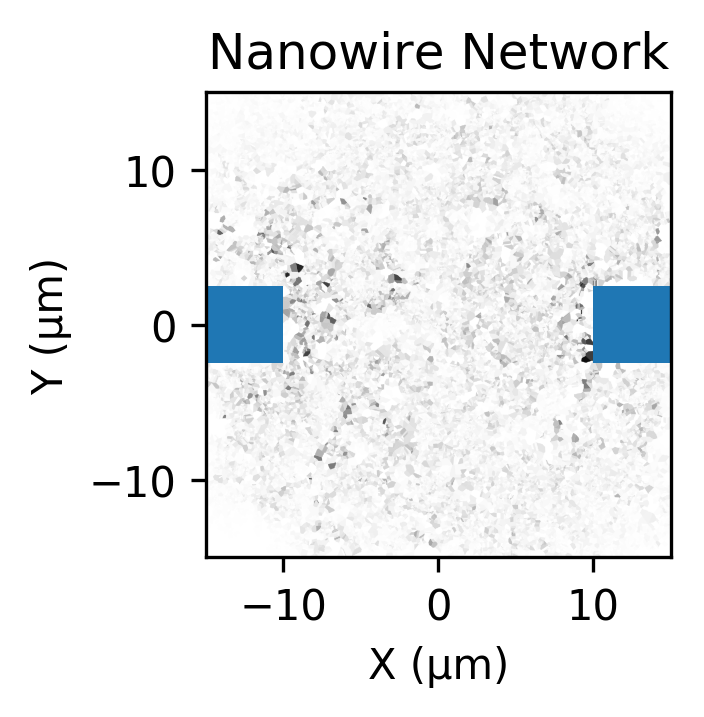

In [278]:
print('Creating network...')

network = create_network(params={
    'width':30, 'height':30,
    'inputs':1, 'outputs':1,
    'e_width':5, 'e_height':5,
    'density':15, # for about 250 nanowires total
    'lalpha':4, 'lloc':0, 'lbeta':0.2,
    #'lalpha':5.77, 'lloc':-0.65, 'lbeta':0.88,
    'seed':0
})

print('Simulating network...')

def voltage_func(time, index):
    voltages = [10,0,0]
    return voltages[index]
   
# use random number in data variable so it isn't written over by other simulations
data = simulate(params={
    'network':network,
    'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
    'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
    'noise_sigma':0.1,
    'dissolution_time':10,
    'voltage_function':voltage_func,
    'max_current':1e-4,
    'max_current_accuracy':0.05,
    'timestep':0.01, 'total_time':.01,
    'seed':0
})

print('Voronoifying network...')

from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.animation as animation

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    From https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram
    
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def polyarea(x,y):
    # from https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates#30408825
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

points = np.array([j['position'] for j in network['junctions']])
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor, radius=None)
polygons = np.array([np.array([vertices[i] for i in region]) for region in regions]) # list of lists of points
edgepairs = [[polygons[i][:,0], polygons[i][:,1]] for i in range(len(polygons))]
areas = np.array([polyarea(edgepairs[i][0], edgepairs[i][1]) for i in range(len(edgepairs))])
currents = np.abs(data['currents'])

print('Drawing voronoi...')
fig = plt.figure(figsize=(2,4),dpi=300)
ax = plt.axes(xlim=(-15, 15), ylim=(-15, 15))
ax.set_aspect('equal')

jpatches = []
for i, point in enumerate(points):
    color = currents[-1][i]/np.max(currents)
    jpatch = patches.Polygon(polygons[i], color=(1-color,1-color,1-color))
    jpatch.set_linewidth(.1)
    jpatches.append(jpatch)
    ax.add_patch(jpatch)
print('Finishing...')
for electrode in network['electrodes']:
    ax.add_patch(patches.Rectangle((electrode['x'], electrode['y']), electrode['w'], electrode['h']))
    
def init():
    return jpatches
def animate(time):
    for i, jpatch in enumerate(jpatches):
        color = currents[time][i]/np.max(currents)
        jpatch.set_color((color,color,color))
    return jpatches
ax.set_xlabel("X (µm)")
ax.set_ylabel("Y (µm)")
ax.set_title('Nanowire Network');
anim = animation.FuncAnimation(fig, animate,
        init_func=init, frames=500, interval=20, blit=True)
#anim.save('network3.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

The above figure is a map of current through a network with two electrodes at a constant voltage difference. Note the current flow approximates current flow through a metal (as should be expected).

---

# Experimental Results

See the files in '../experiment' for experimental data and the 'nanowire_figures.ipynb' notebook for figures of the same. Results generally agree with the conclusions of this document.

---

# Conclusions

## Ruminations on Implications for Computation

Assuming the physical network acts like this model, and assuming the "input voltage, measure current" model of use:

- Networks seem to, on average, rise to a final current exponentially.
- They will not return to a lower current unless voltage input is decreased for a time.
- Every network is purely resistive. This means that the current will always be in phase with the voltage.
- reservoir computing by reading current fluctuations will (almost certainly) not work (for anything but the most simple computations).

- If the network has some capacitance or other higher-order energy storage function, all this could change significantly.

- As is, there is some potential for finite state machine computing.
- Exstant memristor-based computers rely on asymmetric memristors, which these are not.

## Some Possible Applications

- If the time constant is long, one could make a temporary memory---a flash drive that forgets after a time. Potential uses in information security. One could only store small amounts of data (say, 128 bits), but that is enough to transfer a small cryptographic key. Note: the time constant of the physical networks experimented with is measured in weeks, about the right order of magnitude for this application.
- If the time constant is small, with a sufficiently clever electrode arrangement, one can use the network as a finite state machine. This is interesting because network construction doesn't require photolithography or any standard CMOS parts, which require expensive equipment to produce, yet still integrates with electrical systems. A use case might be a self-manufactured circuit for a simple sensor.
- Finally, this network acts like a planar memristor of sorts. I'm not sure why this is useful.

## Future Work

- One might build physical networks with precisely controlled filament formation and decay properties. 
- One might also build capacitance into the network for vastly increased computational ability.